<a href="https://colab.research.google.com/github/teomotun/Restaurant-Plug/blob/main/Yelp_restaurant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [ ]:
#@title GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Oct 22 05:40:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    40W / 300W |    367MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title More memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!apt install -y caffe-cuda
!pip install --upgrade kaggle
!kaggle -v

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Yelp-Restaurant-Classification/kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json

# Change dir to where data folder
%cd drive/
%cd My\ Drive/
%cd Yelp-Restaurant-Classification/Model/
%cd data
!pwd

# Download the kaggle dataset
!kaggle competitions download -c yelp-restaurant-photo-classification

# Unzip and remove zip files
!unzip \*.zip && rm *.zip


In [ ]:
import tarfile
import os

def extract_tgz(filename):
  print("Working on: " + filename)
  tar = tarfile.open(filename, "r:gz")
  tar.extractall()
  tar.close()
  os.remove(filename)
  print("-----------")
  return

tgzs = [
       "sample_submission.csv.tgz", "test_photo_to_biz.csv.tgz",
       "test_photos.tgz", "train.csv.tgz",
       "train_photo_to_biz_ids.csv.tgz", "train_photos.tgz"
       ]

for tgz in tgzs:
  try:
    extract_tgz(tgz)
  except:
    pass

Working on: sample_submission.csv.tgz
Working on: test_photo_to_biz.csv.tgz
Working on: test_photos.tgz
Working on: train.csv.tgz
Working on: train_photo_to_biz_ids.csv.tgz
Working on: train_photos.tgz


In [ ]:
!apt install -y caffe-cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cuda is already the newest version (1.0.0-6build1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


# First Stage


Total training set contains 234842 photos of 2000 restaurants


In [ ]:
#%%writefile training_image_features.py
import numpy as np
import pandas as pd
import tarfile
import skimage
import io
import h5py
import os
import caffe
import time

# Paths
CAFFE_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/caffe/"
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'
DATA_ = "/content/"
# Model creation
# Using bvlc_reference_caffenet model for training
import os
if os.path.isfile(CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    #os.system('/caffe/scripts/download_model_binary.py /caffe/models/bvlc_reference_caffenet')
    !python /content/drive/My\ Drive/Yelp-Restaurant-Classification/Model/caffe/scripts/download_model_binary.py /content/drive/My\ Drive/Yelp-Restaurant-Classification/Model/caffe//models/bvlc_reference_caffenet

model_def = CAFFE_HOME + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

# Create a net object 
model = caffe.Net(model_def,      # defines the structure of the model
            model_weights,  # contains the trained weights
            caffe.TEST)     # use test mode (e.g., don't perform dropout)

# set up transformer - creates transformer object
transformer = caffe.io.Transformer({'data': model.blobs['data'].data.shape})
# transpose image from HxWxC to CxHxW 
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.load(CAFFE_HOME + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
# set raw_scale = 255 to multiply with the values loaded with caffe.io.load_image 
transformer.set_raw_scale('data', 255)
# swap image channels from RGB to BGR 
transformer.set_channel_swap('data', (2, 1, 0))


def extract_features(image_paths):
    """
        This function is used to extract feature from the current batch of photos.
        Features are extracted using the pretrained bvlc_reference_caffenet
        Instead of returning 1000-dim vector from SoftMax layer, using fc7 as the final layer to get 4096-dim vector
    """
    test_size = len(image_paths)
    model.blobs['data'].reshape(test_size, 3, 227, 227)
    model.blobs['data'].data[...] = list(map(lambda x: transformer.preprocess('data', skimage.img_as_float(skimage.io.imread(x)).astype(np.float32) ), image_paths))
    out = model.forward()
    return model.blobs['fc7'].data

if not os.path.isfile(FEATURES_HOME + 'train_features.h5'):
    """
        If this file doesn't exist, create a new one and set up two columns: photoId, feature
    """
    file = h5py.File(FEATURES_HOME + 'train_features.h5', 'w')
    photoId = file.create_dataset('photoId', (0,), maxshape=(None,), dtype='|S54')
    feature = file.create_dataset('feature', (0, 4096), maxshape=(None, 4096), dtype=np.dtype('int16'))
    file.close()

# If this file exists, then track how many of the images are already done.
file = h5py.File(FEATURES_HOME + 'train_features.h5', 'r+')
already_extracted_images = len(file['photoId'])
file.close()

# Get training images and their business ids
train_data = pd.read_csv(DATA_ + 'train_photo_to_biz_ids.csv')
train_photo_paths = [os.path.join(DATA_ + 'train_photos/', str(photo_id) + '.jpg') for photo_id in
                     train_data['photo_id']]

# Each batch will have 500 images for feature extraction
train_size = len(train_photo_paths)
batch_size = 500
batch_number = round(already_extracted_images / batch_size + 1,3)
hours_elapsed = 0

print("Total images:", train_size)
print("already_done_images: ", already_extracted_images)

# Feature extraction of the train dataset
for image_count in range(already_extracted_images, train_size, batch_size):
    start_time = round(time.time(),3)
    # Get the paths for images in the current batch
    image_paths = train_photo_paths[image_count: min(image_count + batch_size, train_size)]

    # Feature extraction for the current batch
    features = extract_features(image_paths)

    # Update the total count of images done so far
    total_done_images = image_count + features.shape[0]

    # Storing the features in h5 file
    file = h5py.File(FEATURES_HOME + 'train_features.h5', 'r+')
    file['photoId'].resize((total_done_images,))
    file['photoId'][image_count: total_done_images] = np.array(image_paths,dtype='|S54')
    file['feature'].resize((total_done_images, features.shape[1]))
    file['feature'][image_count: total_done_images, :] = features
    file.close()

    print("Batch No:", batch_number, "\tStart:", image_count, "\tEnd:", image_count + batch_size, "\tTime elapsed:", hours_elapsed, "hrs", "\tCompleted:", round(float(
        image_count + batch_size) / float(train_size) * 100,3), "%")
    batch_number += 1
    hours_elapsed += round(((time.time() - start_time)/60)/60,3)


Overwriting training_image_features.py


Test set contains 1190225 of 10000 restaurants but I could only load 395500 due to memory constraints

In [ ]:
#%%writefile test_image_features.py
import numpy as np
import pandas as pd
import tarfile
import skimage
import io
import h5py
import os
import caffe
import time

# Paths
CAFFE_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/caffe/"
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'
DATA_ = "/content/"
# Model creation
# Using bvlc_reference_caffenet model for training
import os
if os.path.isfile(CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    #os.system('/caffe/scripts/download_model_binary.py /caffe/models/bvlc_reference_caffenet')
    !python /content/drive/My\ Drive/Yelp-Restaurant-Classification/Model/caffe/scripts/download_model_binary.py /content/drive/My\ Drive/Yelp-Restaurant-Classification/Model/caffe//models/bvlc_reference_caffenet

model_def = CAFFE_HOME + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

# Create a net object 
model = caffe.Net(model_def,      # defines the structure of the model
            model_weights,  # contains the trained weights
            caffe.TEST)     # use test mode (e.g., don't perform dropout)

# set up transformer - creates transformer object
transformer = caffe.io.Transformer({'data': model.blobs['data'].data.shape})
# transpose image from HxWxC to CxHxW 
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.load(CAFFE_HOME + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
# set raw_scale = 255 to multiply with the values loaded with caffe.io.load_image 
transformer.set_raw_scale('data', 255)
# swap image channels from RGB to BGR 
transformer.set_channel_swap('data', (2, 1, 0))


def extract_features(image_paths):
    """
        This function is used to extract feature from the current batch of photos.
        Features are extracted using the pretrained bvlc_reference_caffenet
        Instead of returning 1000-dim vector from SoftMax layer, using fc7 as the final layer to get 4096-dim vector
    """
    test_size = len(image_paths)
    model.blobs['data'].reshape(test_size, 3, 227, 227)
    model.blobs['data'].data[...] = list(map(lambda x: transformer.preprocess('data', skimage.img_as_float(skimage.io.imread(x)).astype(np.float32) ), image_paths))
    out = model.forward()
    return model.blobs['fc7'].data

if not os.path.isfile(FEATURES_HOME + 'test_features.h5'):
    """
        If this file doesn't exist, create a new one and set up two columns: photoId, feature
    """
    file = h5py.File(FEATURES_HOME + 'test_features.h5', 'w')
    photoId = file.create_dataset('photoId', (0,), maxshape=(None,), dtype='|S54')
    feature = file.create_dataset('feature', (0, 4096), maxshape=(None, 4096), dtype=np.dtype('int16'))
    file.close()

# If this file exists, then track how many of the images are already done.
file = h5py.File(FEATURES_HOME + 'test_features.h5', 'r+')
already_extracted_images = len(file['photoId'])
file.close()

# Get testing images and their business ids
test_data = pd.read_csv(DATA_HOME + 'test_photo_to_biz.csv')
test_photo_paths = [os.path.join(DATA_ + 'test_photos/', str(photo_id) + '.jpg') for photo_id in
                     test_data['photo_id']]

# Each batch will have 500 images for feature extraction
test_size = 395500#len(test_photo_paths)
batch_size = 500
batch_number = round(already_extracted_images / batch_size + 1,3)
hours_elapsed = 0

print("Total images:", test_size)
print("already_done_images: ", already_extracted_images-500)

# Feature extraction of the test dataset
for image_count in range(already_extracted_images, test_size, batch_size):
    start_time = round(time.time(),3)
    # Get the paths for images in the current batch
    image_paths = test_photo_paths[image_count: min(image_count + batch_size, test_size)]

    # Feature extraction for the current batch
    features = extract_features(image_paths)

    # Update the total count of images done so far
    total_done_images = image_count + features.shape[0]

    # Storing the features in h5 file
    file = h5py.File(FEATURES_HOME + 'test_features.h5', 'r+')
    try:
      file['photoId'].resize((total_done_images,))
      file['photoId'][image_count: total_done_images] = np.array(image_paths,dtype='|S54')
      file['feature'].resize((total_done_images, features.shape[1]))
      file['feature'][image_count: total_done_images, :] = features
      file.close()
    except Exception as e:
      print(e)
      file.close()

    print("Batch No:", batch_number, "\tStart:", image_count, "\tEnd:", image_count + batch_size, "\tTime elapsed:", hours_elapsed, "hrs", "\tCompleted:", round(float(
        image_count + batch_size) / float(test_size) * 100,3), "%")
    batch_number += 1
    hours_elapsed += round(((time.time() - start_time)/60)/60,3)


Writing test_image_features.py


# Second Stage

Restaurant aggregation of training features

In [ ]:
#%%writefile training_restaurant_features.py
import pandas as pd
import h5py

# Paths
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'

# Get photo->business mapping from the file provided
train_photo_to_biz_ids = pd.read_csv(DATA_HOME + 'train_photo_to_biz_ids.csv')

# Get labels for businesses in the training data
train_data_business = pd.read_csv(DATA_HOME + 'train.csv').dropna()

# Sort these labels in the ascending order for simplicity e.g. (0, 6, 4, 2, 5) -> (0, 2, 4, 5, 6)
train_data_business['labels'] = train_data_business['labels'].apply(
    lambda feature_vector: tuple(sorted(int(feature) for feature in feature_vector.split())))
train_data_business.set_index('business_id', inplace=True)

# Get business ids
business_ids = train_data_business.index.unique()
print("Total train business:", len(business_ids))

# Reading stored features from h5 file
train_features_file = h5py.File(FEATURES_HOME + 'train_features.h5', 'r')
train_features = np.copy(train_features_file['feature'])
train_features_file.close()

# Create a pandas dataframe to make the data ready for training the SVM classifier in the following format
train_df = pd.DataFrame(columns=['business_id', 'label', 'feature'])

for business_id in business_ids:
    """
        For each business, write the values for the above triplet in the file viz. ['business_id', 'label', 'feature']
    """
    business_id = int(business_id)

    # Get the labels for the current business
    label = train_data_business.loc[business_id]['labels']

    # Get all the images which represent the current business with business_id
    images_for_business_id = train_photo_to_biz_ids[train_photo_to_biz_ids['business_id'] == business_id].index.tolist()

    # As a feature for current business, take the average over all the images
    feature = list(np.mean(train_features[images_for_business_id], axis=0))

    # Put the triplet into the data frame
    train_df.loc[business_id] = [business_id, label, feature]

print("Train business feature extraction is completed.")

# Write the above data frame into a csv file
with open(FEATURES_HOME + 'train_aggregate_features.csv', 'w') as business_features_file:
    train_df.to_csv(business_features_file, index=False)


Writing training_restaurant_features.py


In [ ]:
train_df.head()

,business_id,label,feature
1000,1000,"(1, 2, 3, 4, 5, 6, 7)","[0.14814814814814814, 0.2962962962962963, 0.14..."
1001,1001,"(0, 1, 6, 8)","[0.0, 0.3333333333333333, 0.4444444444444444, ..."
100,100,"(1, 2, 4, 5, 6, 7)","[0.08333333333333333, 0.011904761904761904, 0...."
1006,1006,"(1, 2, 4, 5, 6)","[0.045454545454545456, 0.0, 0.0, 0.59090909090..."
1010,1010,"(0, 6, 8)","[0.2727272727272727, 0.18181818181818182, 0.0,..."


In [ ]:
train_df.shape

(1996, 3)

Restaurant aggregation of test features

In [ ]:
#%%writefile testing_restaurant_features.py
import numpy as np
import pandas as pd
import h5py

# Paths
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'

# Get photo->business mapping from the file provided
test_photo_to_biz_ids = pd.read_csv(DATA_HOME + 'test_photo_to_biz.csv')[:395500]

# Get business ids
business_ids = test_photo_to_biz_ids['business_id'].unique()
print("Total test business:", len(business_ids))

# Reading stored features from h5 file
test_features_file = h5py.File(FEATURES_HOME + 'test_features.h5', 'r')
# test_features = test_features_file['feature']
# test_features_file.close()

print(test_features_file['feature'][0])

# Create a pandas dataframe to make the data ready for training the SVM classifier in the following format
# Note that there will not be 'label' column as this is the actual testing data provided by Yelp
test_df = pd.DataFrame(columns=['business_id', 'feature'])

id = 0
for business_id in business_ids:
    """
        For each business, write the values for the above tuple in the file viz. ['business_id', 'feature']
    """

    # Get all the images which represent the current business with business_id
    images_for_business_id = test_photo_to_biz_ids[test_photo_to_biz_ids['business_id'] == business_id].index.tolist()

    # images_for_business_id[0]:(images_for_business_id[-1]+1)
    # As a feature for current business, take the average over all the images
    feature = list(
        np.mean(np.asarray(test_features_file['feature'][:395500,:][images_for_business_id[0]:(images_for_business_id[-1] + 1)]),
                axis=0))

    # Put the tuple into the data frame
    test_df.loc[business_id] = [business_id, feature]
    id += 1
    if id % 100 == 0:
        print("ID:", id)

print("Test business feature extraction is completed.")
test_features_file.close()

# Write the above data frame into a csv file
with open(FEATURES_HOME + 'test_aggregated_features.csv', 'w') as business_features_file:
    test_df.to_csv(business_features_file, index=False)

Writing testing_restaurant_features.py


In [ ]:
test_df.head()

,business_id,feature
003sg,003sg,"[0.1317365269461078, 0.18562874251497005, 0.11..."
00er5,00er5,"[0.14285714285714285, 0.19047619047619047, 0.1..."
00kad,00kad,"[0.08433734939759036, 0.07228915662650602, 0.0..."
00mc6,00mc6,"[0.26666666666666666, 0.13333333333333333, 0.3..."
00q7x,00q7x,"[0.16666666666666666, 0.25, 0.2083333333333333..."


In [ ]:
test_df.shape

(3294, 2)

# 3rd Stage

Training Restaurant Label Classifier on Training and Validation Set

SVC, KNN, RF, Extratrees Model, Stacking Model of 4 of them and a Stack of 3 KNN AND 1 RF

In [ ]:
#%%writefile training_classification_model.py
import numpy as np
import statistics
import pandas as pd
import time
import os

from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib

def get_labels(label_string):
    """
        This function converts label from string to array of labels
        Input: "(1, 2, 3, 4, 5)"
        Output: [1, 2, 3, 4, 5]
    """
    label_array = label_string[1:-1]
    label_array = label_array.split(',')
    label_array = [int(label) for label in label_array if len(label) > 0]
    return label_array


def get_features(feature_string):
    """
        This function converts feature vector from string to array of features
        Input: "(1.2, 3.4, ..., 9.10)"
        Output: [1.2, 3.4, ..., 9.10]
    """
    feature_array = feature_string[1:-1]
    feature_array = feature_array.split(',')
    feature_array = [float(label) for label in feature_array]
    return feature_array


# Set home paths for data and features
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'
MODELS_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/model/'

# Read training data and test data
train_data = pd.read_csv(FEATURES_HOME + 'train_aggregate_features.csv')

# Separate the labels from features in the training data
trainX = np.array([get_features(feature) for feature in train_data['feature']])
trainY = np.array([get_labels(label) for label in train_data['label']])

# Use validation data for calculating the training accuracy, random_state ensures reproducible results without overfitting
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.3, random_state=42)

# Binary representation (just like one-hot vector) (1, 3, 5, 9) -> (1, 0, 1, 0, 1, 0, 0, 0, 1)
mlb = MultiLabelBinarizer()
trainY = mlb.fit_transform(trainY)

# Do the same for validation labels
actual_labels = validationY
mlb = MultiLabelBinarizer()
validationY = mlb.fit_transform(validationY)

svc_clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, verbose=True))
rf_clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42)
knn_clf = KNeighborsClassifier()
extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)


for clf in [svc_clf, rf_clf, knn_clf, extra_tree_clf]:
    if not os.path.isfile(MODELS_HOME + f'{clf.__class__.__name__}.pkl'):
      # Start time
        start_time = time.time()

        # Fit the classifier on the training data and labels
        clf.fit(trainX, trainY)
        cross_val = cross_val_predict(clf, validationX, validationY, cv=3)

        print(f"{clf.__class__.__name__} trained.")

        joblib.dump((mlb,clf), MODELS_HOME + f'{clf.__class__.__name__}.pkl')
        print("Model saved.")
        
        # End time
        end_time = time.time()

        print(f"Overall F1 Score for {clf.__class__.__name__}:", f1_score(cross_val, validationY, average='micro'))
        print(f"Individual F1 Score for {clf.__class__.__name__}:", f1_score(cross_val, validationY, average=None))
        print(f"Variance of {clf.__class__.__name__} is:", statistics.variance(f1_score(cross_val, validationY, average=None)))
        print(f"Time taken for training the {clf.__class__.__name__}", end_time - start_time, "sec")
        print("======================================================")
        print("\n")

    mlb,clf = joblib.load(MODELS_HOME + f'{clf.__class__.__name__}'+".pkl")

    print(f"{clf.__class__.__name__} Model loaded.")

    # Predict the labels for the validation data
    preds_binary = clf.predict(validationX)

    # Predicted labels are converted back
    # (1, 0, 1, 0, 1, 0, 0, 0, 1) -> (1, 3, 5, 9)
    predicted_labels = mlb.inverse_transform(preds_binary)

    print("Validation Set Results:")
    print(f"Overall F1 Score for {clf.__class__.__name__}:", f1_score(preds_binary, validationY, average='micro'))
    print(f"Individual F1 Score for {clf.__class__.__name__}:", f1_score(preds_binary, validationY, average=None))
    print(f"Variance of {clf.__class__.__name__} is:", statistics.variance(f1_score(preds_binary, validationY, average=None)))
    print("======================================================")


X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(trainX, trainY, random_state=42)


svc_clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, verbose=True))
rf_clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42)
knn_clf = KNeighborsClassifier()
extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)


start_time = time.time()
rnd_clf_2 = RandomForestClassifier(random_state=42)

for p in [svc_clf, rf_clf, knn_clf, extra_tree_clf]:
    p.fit(X_train_1, y_train_1)

svc_clf_p = svc_clf.predict(X_train_2)
rf_clf_p = rf_clf.predict(X_train_2)
knn_clf_p = knn_clf.predict(X_train_2)

held_out = np.column_stack((svc_clf_p, rf_clf_p, knn_clf_p))
rnd_clf_2.fit(held_out, y_train_2)

result_1 = []
for p in [svc_clf, rf_clf, knn_clf]:
    result_1.append(p.predict(validationX))

y_pred_s = rnd_clf_2.predict(np.column_stack(tuple(result_1)))
# End time
end_time = time.time()

print(f"Time taken for training the Stacked Model:", end_time - start_time, "sec")
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average='micro'))
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average=None))
print(f"Variance of Stacked Model is:", statistics.variance(f1_score(y_pred_s, validationY, average=None)))


OneVsRestClassifier Model loaded.
Validation Set Results:
Overall F1 Score for OneVsRestClassifier: 0.7990927990927991
Individual F1 Score for OneVsRestClassifier: [0.60821918 0.78683386 0.83279743 0.62875197 0.77777778 0.85
 0.92831106 0.75630252 0.85305592]
Variance of OneVsRestClassifier is: 0.011002283060912728
RandomForestClassifier Model loaded.
Validation Set Results:
Overall F1 Score for RandomForestClassifier: 0.8051592730115301
Individual F1 Score for RandomForestClassifier: [0.59756098 0.81043478 0.86046512 0.66339869 0.67114094 0.86500655
 0.92915215 0.66875    0.8707124 ]
Variance of RandomForestClassifier is: 0.014429551073964162
KNeighborsClassifier Model loaded.
Validation Set Results:
Overall F1 Score for KNeighborsClassifier: 0.8065585851142225
Individual F1 Score for KNeighborsClassifier: [0.58682635 0.82067851 0.86060606 0.68733154 0.75213675 0.85505481
 0.91734575 0.70623145 0.85673759]
Variance of KNeighborsClassifier is: 0.011325120339131595
ExtraTreesClassifier 

[link text](https://)Stack of 3 KNN AND 1 RF

In [ ]:
#%%writefile training_classification_model.py
import numpy as np
import statistics
import pandas as pd
import time
import os

from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib

def get_labels(label_string):
    """
        This function converts label from string to array of labels
        Input: "(1, 2, 3, 4, 5)"
        Output: [1, 2, 3, 4, 5]
    """
    label_array = label_string[1:-1]
    label_array = label_array.split(',')
    label_array = [int(label) for label in label_array if len(label) > 0]
    return label_array


def get_features(feature_string):
    """
        This function converts feature vector from string to array of features
        Input: "(1.2, 3.4, ..., 9.10)"
        Output: [1.2, 3.4, ..., 9.10]
    """
    feature_array = feature_string[1:-1]
    feature_array = feature_array.split(',')
    feature_array = [float(label) for label in feature_array]
    return feature_array


# Set home paths for data and features
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
FEATURES_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/features/'
MODELS_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/model/'

# Read training data and test data
train_data = pd.read_csv(FEATURES_HOME + 'train_aggregate_features.csv')

# Separate the labels from features in the training data
trainX = np.array([get_features(feature) for feature in train_data['feature']])
trainY = np.array([get_labels(label) for label in train_data['label']])

# Use validation data for calculating the training accuracy, random_state ensures reproducible results without overfitting
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.3, random_state=42)

# Binary representation (just like one-hot vector) (1, 3, 5, 9) -> (1, 0, 1, 0, 1, 0, 0, 0, 1)
mlb = MultiLabelBinarizer()
trainY = mlb.fit_transform(trainY)

# Do the same for validation labels
actual_labels = validationY
mlb = MultiLabelBinarizer()
validationY = mlb.fit_transform(validationY)

svc_clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, verbose=True))
rf_clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42)
knn_clf = KNeighborsClassifier()
extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)


for clf in [svc_clf, rf_clf, knn_clf, extra_tree_clf]:
    if not os.path.isfile(MODELS_HOME + f'{clf.__class__.__name__}.pkl'):
      # Start time
        start_time = time.time()

        # Fit the classifier on the training data and labels
        clf.fit(trainX, trainY)
        cross_val = cross_val_predict(clf, validationX, validationY, cv=3)

        print(f"{clf.__class__.__name__} trained.")

        joblib.dump((mlb,clf), MODELS_HOME + f'{clf.__class__.__name__}.pkl')
        print("Model saved.")
        
        # End time
        end_time = time.time()

        print(f"Overall F1 Score for {clf.__class__.__name__}:", f1_score(cross_val, validationY, average='micro'))
        print(f"Individual F1 Score for {clf.__class__.__name__}:", f1_score(cross_val, validationY, average=None))
        print(f"Variance of {clf.__class__.__name__} is:", statistics.variance(f1_score(cross_val, validationY, average=None)))
        print(f"Time taken for training the {clf.__class__.__name__}", end_time - start_time, "sec")
        print("======================================================")
        print("\n")

    mlb,clf = joblib.load(MODELS_HOME + f'{clf.__class__.__name__}'+".pkl")

    print(f"{clf.__class__.__name__} Model loaded.")

    # Predict the labels for the validation data
    preds_binary = clf.predict(validationX)

    # Predicted labels are converted back
    # (1, 0, 1, 0, 1, 0, 0, 0, 1) -> (1, 3, 5, 9)
    predicted_labels = mlb.inverse_transform(preds_binary)

    print("Validation Set Results:")
    print(f"Overall F1 Score for {clf.__class__.__name__}:", f1_score(preds_binary, validationY, average='micro'))
    print(f"Individual F1 Score for {clf.__class__.__name__}:", f1_score(preds_binary, validationY, average=None))
    print(f"Variance of {clf.__class__.__name__} is:", statistics.variance(f1_score(preds_binary, validationY, average=None)))
    print("======================================================")


X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(trainX, trainY, random_state=42)


svc_clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, verbose=True))
rf_clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42)
knn_clf = KNeighborsClassifier()
extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)


start_time = time.time()
rnd_clf_2 = RandomForestClassifier(random_state=42)

for p in [svc_clf, rf_clf, knn_clf, extra_tree_clf]:
    p.fit(X_train_1, y_train_1)

svc_clf_p = svc_clf.predict(X_train_2)
rf_clf_p = rf_clf.predict(X_train_2)
knn_clf_p = knn_clf.predict(X_train_2)

held_out = np.column_stack((svc_clf_p, rf_clf_p, knn_clf_p))
rnd_clf_2.fit(held_out, y_train_2)

result_1 = []
for p in [svc_clf, rf_clf, knn_clf]:
    result_1.append(p.predict(validationX))

y_pred_s = rnd_clf_2.predict(np.column_stack(tuple(result_1)))
# End time
end_time = time.time()

print(f"Time taken for training the Stacked Model:", end_time - start_time, "sec")
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average='micro'))
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average=None))
print(f"Variance of Stacked Model is:", statistics.variance(f1_score(y_pred_s, validationY, average=None)))



X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(trainX, trainY, random_state=42)
start_time = time.time()
rnd_clf1 = RandomForestClassifier(random_state=42)
knn_clf1 = KNeighborsClassifier()
knn_clf2 = KNeighborsClassifier()
knn_clf3 = KNeighborsClassifier()
knn_clf4 = KNeighborsClassifier()

rnd_clf2 = RandomForestClassifier(random_state=42)

for p in [knn_clf1, knn_clf2, knn_clf3, rnd_clf1]:
    p.fit(X_train_1, y_train_1)

knn_clf1_p = knn_clf1.predict(X_train_2)
knn_clf2_p = knn_clf2.predict(X_train_2)
knn_clf3_p = knn_clf3.predict(X_train_2)
rnd_clf1_p = rnd_clf1.predict(X_train_2)

held_out = np.column_stack((knn_clf1_p, knn_clf2_p, knn_clf3_p, rnd_clf1_p))
rnd_clf_2.fit(held_out, y_train_2)

result_1 = []
for p in [knn_clf1, knn_clf1, knn_clf3, rnd_clf1]:
    result_1.append(p.predict(validationX))

y_pred_s = rnd_clf_2.predict(np.column_stack(tuple(result_1)))
# End time
end_time = time.time()

print(f"Time taken for training the Stacked Model:", end_time - start_time, "sec")
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average='micro'))
print(f"Overall Stacked F1 Score for:", f1_score(y_pred_s, validationY, average=None))
print(f"Variance of Stacked Model is:", statistics.variance(f1_score(y_pred_s, validationY, average=None)))



Time taken for training the Stacked Model: 34.323143005371094 sec
Overall Stacked F1 Score for: 0.7776704655205718
Overall Stacked F1 Score for: [0.61081081 0.79333333 0.85113269 0.56157635 0.68882175 0.83665339
 0.91105769 0.68023256 0.84166667]
Variance of Stacked Model is: 0.01467163770907351


Random Forest algorithm: 
Average F1 => 0.80516; 
Time taken to train => 17.7761 sec;
Variance => 0.01443

SVC algorithm: 
Average F1 => 0.79910; 
Time taken to train => 295.4199 sec; 
Variance => 0.01100

KNN algorithm: 
Average F1 => 0.80656; 
Time taken to train => 2.7335 sec; 
Variance => 0.01132

Extratrees algorithm: 
Average F1 => 0.76833;
Time taken to train => 3.6577 sec;
Variance => 0.03619

Stacked algorithm (RF, SVC, KNN, Extratrees): 
Average F1 => 0.79852; 
Time taken to train => 165.1282 sec; 
Variance => 0.01412

Stacked algorithm (RF, KNN, KNN, KNN): 
Average F1 =>  0.77767; 
Time taken to train => 34.3231 sec; 
Variance => 0.01467



KNN and Random Forest appears to outperform the other models in terms of time, variance and F1 score with both over 80% across all classes. Stacking the best two predictors seem to have an adverse effect on the model. 

I'll stick with KNN for the rest of my analysis and testing

# KNN Model Analysis

Compute ROC curve and ROC area for each class and Confusion Matrix of each class

Automatically created module for IPython interactive environment
0
     0   1
0  363  93
1   45  98

1
     0    1
0  234   70
1   41  254

2
     0    1
0  223   36
1   56  284

3
     0    1
0  112   67
1  165  255

4
     0    1
0  380   31
1   56  132

5
     0    1
0  129   30
1   89  351

6
     0    1
0  134   18
1   53  394

7
     0    1
0  381   61
1   38  119

8
     0    1
0  196   69
1   32  302



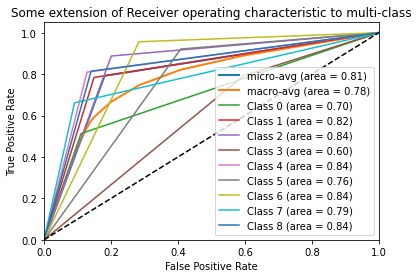

In [ ]:
#%%writefile model_analysis.py
import numpy as np
import statistics
import pandas as pd
import time
import os
print(__doc__)
from itertools import cycle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

MODELS_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/model/'
mlb,clf = joblib.load(MODELS_HOME + "KNeighborsClassifier.pkl")

# Predict the labels for the validation data
preds_binary = clf.predict(validationX)

# Predicted labels are converted back
# (1, 0, 1, 0, 1, 0, 0, 0, 1) -> (1, 3, 5, 9)
predicted_labels = mlb.inverse_transform(preds_binary)

conf_mx = multilabel_confusion_matrix(preds_binary,validationY)
i = 0
for conf in conf_mx:
    print(i)
    print(pd.DataFrame(conf))
    print("======\n")
    i += 1

n_classes = preds_binary.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(validationY[:, i], preds_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

n_classes = preds_binary.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(validationY[:, i], preds_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(preds_binary.ravel(), validationY.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-avg (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Testing 3 stage model on new data



In [ ]:
#%%writefile get_prediction.py
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import tarfile
import skimage
import io
import h5py
import os
import caffe
import time




def get_predictions(RESTAURANT_HOME, CAFFE_HOME, DATA_HOME, MODELS_HOME):
    """
        This function is used to make restaurant class prediction of photos from several directory paths.
        Features are extracted using the pretrained bvlc_reference_caffenet
        Instead of returning 1000-dim vector from SoftMax layer, using fc7 as the final layer to get 4096-dim vector.
        The features are the passed to a KNN multi label classifier
    """

    # Model creation
    # Using bvlc_reference_caffenet model for training
    import os
    if os.path.isfile(CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
        print('CaffeNet found.')

    model_def = CAFFE_HOME + 'models/bvlc_reference_caffenet/deploy.prototxt'
    model_weights = CAFFE_HOME + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

    # Create a net object 
    model = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    # set up transformer - creates transformer object
    transformer = caffe.io.Transformer({'data': model.blobs['data'].data.shape})
    # transpose image from HxWxC to CxHxW 
    transformer.set_transpose('data', (2, 0, 1))
    transformer.set_mean('data', np.load(CAFFE_HOME + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
    # set raw_scale = 255 to multiply with the values loaded with caffe.io.load_image 
    transformer.set_raw_scale('data', 255)
    # swap image channels from RGB to BGR 
    transformer.set_channel_swap('data', (2, 1, 0))

    def extract_features(image_paths):
        """
            This function is used to extract feature from the current batch of photos.
            Features are extracted using the pretrained bvlc_reference_caffenet
            Instead of returning 1000-dim vector from SoftMax layer, using fc7 as the final layer to get 4096-dim vector
        """
        test_size = len(image_paths)
        model.blobs['data'].reshape(test_size, 3, 227, 227)
        model.blobs['data'].data[...] = list(map(lambda x: transformer.preprocess('data', skimage.img_as_float(skimage.io.imread(x)).astype(np.float32) ), image_paths))
        out = model.forward()
        return model.blobs['fc7'].data

    features = extract_features(image_paths)

    mlb,clf = joblib.load(MODELS_HOME + "KNeighborsClassifier.pkl")

    # Predict the labels for the validation data
    preds_binary = clf.predict(features)

    # Predicted labels are converted back
    # (1, 0, 1, 0, 1, 0, 0, 0, 1) -> (1, 3, 5, 9)
    predicted_labels = mlb.inverse_transform(preds_binary)
    return predicted_labels
      

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Paths
CAFFE_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/caffe/"
DATA_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/data/"
MODELS_HOME = '/content/drive/My Drive/Yelp-Restaurant-Classification/Model/model/'
RESTAURANT_HOME = "/content/drive/My Drive/Yelp-Restaurant-Classification/Model/restaurant-images/"


image_paths = [RESTAURANT_HOME+f.strip() for f in os.listdir(RESTAURANT_HOME) if os.path.isfile(RESTAURANT_HOME + f)]

get_predictions(image_paths, CAFFE_HOME, DATA_HOME, MODELS_HOME)

CaffeNet found.


[(2, 3, 4, 5, 6, 7),
 (0, 2, 3, 5, 6, 8),
 (2, 3, 5, 6),
 (0, 2, 3, 4, 5, 6, 7, 8),
 (1, 2, 5, 6, 8),
 (2, 3, 4, 5, 6, 8),
 (3, 5, 6, 8),
 (0, 3, 6, 8),
 (2, 3, 5, 6),
 (6, 8),
 (3, 5, 6, 8),
 (0, 3, 8),
 (1, 3, 5, 6),
 (2, 5, 6),
 (0, 3, 8),
 (2, 4, 5, 6, 7),
 (2, 3, 4, 5, 6, 7),
 (2, 3, 4, 5, 6, 7),
 (0, 2, 3, 4, 5, 6, 7),
 (2, 3, 4, 5, 6, 7),
 (0, 3, 6, 8),
 (3, 8),
 (3, 5, 6),
 (0, 2, 3, 4, 5, 6, 8),
 (2, 3, 4, 5, 6),
 (0, 2, 3, 4, 5, 6, 8),
 (0, 2, 3, 5, 6, 8),
 (0, 3, 5, 6, 8),
 (0, 2, 3, 4, 5, 6, 7, 8),
 (0, 2, 3, 5, 6, 8),
 (0, 2, 3, 4, 5, 6, 8),
 (2, 3, 4, 5, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7, 8),
 (2, 3, 4, 5, 6, 7),
 (1, 2, 3, 4, 5, 6, 7),
 (2, 3, 5, 6),
 (2, 3, 5, 6),
 (3, 5, 6),
 (3, 5, 6),
 (2, 3, 5, 6),
 (0, 3, 5, 6, 8),
 (0, 3, 5, 6),
 (1, 2, 5, 6),
 (2, 4, 5, 6, 7, 8),
 (2, 3, 5, 6, 8),
 (1, 2, 3, 5, 6),
 (1, 2, 3, 4, 5, 6),
 (0, 2, 3, 5, 6)]

In [ ]:
RESTAURANT_HOME

'/content/drive/My Drive/Yelp-Restaurant-Classification/Model/restaurant-images/'